## Notebook to run alignment comparison experiments 

In [3]:
%load_ext autoreload
%autoreload 2

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnEigenModels as eigModels
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutil

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [6]:
# Define experiment settings
numEach = 1
trainingEpochs = 10
learningRate = 5e-1
dropoutSetting = 0.5
weightDecaySetting = learningRate * 1e-1
verbose = False
useNet = {0:'MLP4',1:'eigNet'}
richInfo = False

runExperiment = True
saveResults = False

if runExperiment:
    # Saving Parameters
    saveDir=Path('../data/networkComparisonDropoutRegularRichInfo')
    if not os.path.exists(saveDir): os.makedirs(saveDir)

    # Run experiment
    pDropout = np.repeat([0,0,dropoutSetting,0],numEach)
    weightDecay = np.repeat([0,weightDecaySetting,0,0],numEach)
    useNetID = np.repeat([0,0,0,1],numEach)
    fullResults = nnexp.compareAlignmentDropout(useNet=useNet,useNetID=useNetID,DEVICE=DEVICE,iterations=trainingEpochs,learningRate=learningRate,pDropout=pDropout,weightDecay=weightDecay,verbose=verbose,richInfo=richInfo)

    if saveResults:
        fileName = f'networkComparison_{useNet}_{date.today()}.pkl'
        with open(saveDir / fileName, 'wb') as f:
            pickle.dump(fullResults, f)

Initiating experiment using cuda
Network 1/4 finished in 29.7 seconds. pDropout:0.0. WeightDecay:0.0. Test loss:0.10. Test accuracy: 97.06%.
Network 2/4 finished in 29.9 seconds. pDropout:0.0. WeightDecay:0.05. Test loss:1.27. Test accuracy: 54.63%.
Network 3/4 finished in 30.1 seconds. pDropout:0.5. WeightDecay:0.0. Test loss:0.14. Test accuracy: 96.11%.
Running fitEigenstructure...
Network 4/4 finished in 33.2 seconds. pDropout:0.0. WeightDecay:0.0. Test loss:0.54. Test accuracy: 87.31%.


In [2]:
# Load results from previous run
useNet = 'MLP4'
# fileNames = glob(f"../data/networkComparisonDropoutRegular/networkComparison_{useNet}_*.pkl")
fileNames = glob(f"../data/networkComparisonDropoutRegularRichInfo/networkComparison_{useNet}_*07.pkl")
NF = len(fileNames)
if NF>1: raise ValueError("Didn't prepare for this")

with open(fileNames[0],'rb') as f:
    fullResults = pickle.load(f)
    
pDropout = np.array([fr['pDropout'] for fr in fullResults])
weightDecay = np.array([fr['cWeightDecay'] for fr in fullResults])

In [8]:
numRuns = len(fullResults)
numLayers = len(fullResults[0]['alignFull'][0])
alignFull = [res['alignFull'] for res in fullResults]
alignMean = torch.stack([res['net'].avgFromFull(res['alignFull']) for res in fullResults])
alignLayer = [[] for _ in range(numLayers)]
for layer in tqdm(range(numLayers)):
    # First put each layers alignment trajectory as a list in alignLayer
    for runidx in range(numRuns):
        alignLayer[layer].append(fullResults[runidx]['net'].layerFromFull(alignFull[runidx],layer))
    # Then concatenate across them all, so we have a (numRuns, numNodes, numEpochs) tensor describing alignment trajectory
    alignLayer[layer] = torch.stack(alignLayer[layer])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 59.70it/s]


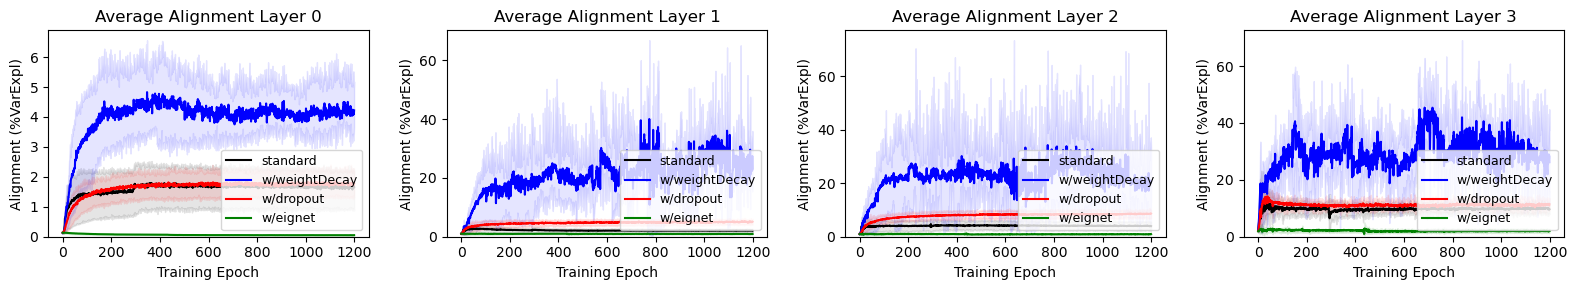

In [ ]:
idxStandard = np.where(np.logical_and(np.logical_and(pDropout==0,weightDecay==0),useNetID==0))[0]
idxDropout = np.where(pDropout!=0)[0]
idxRegular = np.where(weightDecay!=0)[0]
idxEignet = np.where(useNetID!=0)[0]
numEpoch = alignLayer[0].shape[2]

qRange = (0.2,0.8)

fig, ax = plt.subplots(1,numLayers,figsize=(16,3))
for layer in range(numLayers):
    mnStandard = 100*torch.mean(alignMean[idxStandard,layer,:],dim=0)
    seStandard = 100*torch.std(alignMean[idxStandard,layer,:],dim=0)
    mnDropout = 100*torch.mean(alignMean[idxDropout,layer,:],dim=0)
    seDropout = 100*torch.std(alignMean[idxDropout,layer,:],dim=0)
    mnRegular = 100*torch.mean(alignMean[idxRegular,layer,:],dim=0)
    seRegular = 100*torch.std(alignMean[idxRegular,layer,:],dim=0)
    mnEignet = 100*torch.mean(alignMean[idxEignet,layer,:],dim=0)
    seEignet = 100*torch.std(alignMean[idxEignet,layer,:],dim=0)
    
    uqStandard = 100*torch.mean(torch.quantile(alignLayer[layer][idxStandard,:,:],q=qRange[1],dim=1),dim=0)
    lqStandard = 100*torch.mean(torch.quantile(alignLayer[layer][idxStandard,:,:],q=qRange[0],dim=1),dim=0)
    uqDropout = 100*torch.mean(torch.quantile(alignLayer[layer][idxDropout,:,:],q=qRange[1],dim=1),dim=0)
    lqDropout = 100*torch.mean(torch.quantile(alignLayer[layer][idxDropout,:,:],q=qRange[0],dim=1),dim=0)
    uqRegular = 100*torch.mean(torch.quantile(alignLayer[layer][idxRegular,:,:],q=qRange[1],dim=1),dim=0)
    lqRegular = 100*torch.mean(torch.quantile(alignLayer[layer][idxRegular,:,:],q=qRange[0],dim=1),dim=0)
    uqEignet = 100*torch.mean(torch.quantile(alignLayer[layer][idxEignet,:,:],q=qRange[1],dim=1),dim=0)
    lqEignet = 100*torch.mean(torch.quantile(alignLayer[layer][idxEignet,:,:],q=qRange[0],dim=1),dim=0)
    
    ax[layer].plot(range(numEpoch), mnStandard, c='k', linewidth=1.5, label='standard')
    ax[layer].plot(range(numEpoch), mnRegular, c='b', linewidth=1.5, label='w/weightDecay')
    ax[layer].plot(range(numEpoch), mnDropout, c='r', linewidth=1.5, label='w/dropout')
    ax[layer].plot(range(numEpoch), mnEignet, c='g', linewidth=1.5, label='w/eignet')
    
    # Interdecile range
    ax[layer].fill_between(range(numEpoch), uqStandard, lqStandard, color='k', alpha=0.1)
    ax[layer].fill_between(range(numEpoch), uqRegular, lqRegular, color='b', alpha=0.1)
    ax[layer].fill_between(range(numEpoch), uqDropout, lqDropout, color='r', alpha=0.1)
    ax[layer].fill_between(range(numEpoch), uqEignet, lqEignet, color='g', alpha=0.1)
    
    # Labels
    ax[layer].set_ylim(0)
    ax[layer].set_xlabel('Training Epoch')
    ax[layer].set_ylabel('Alignment (%VarExpl)')
    ax[layer].set_title(f'Average Alignment Layer {layer}')
    ax[layer].legend(fontsize=9,loc='lower right')
    
plt.tight_layout()

In [5]:
preprocess = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
    transforms.Lambda(torch.flatten), # convert to vectors
])
trainloader, testloader, numClasses = nnutil.downloadMNIST(batchSize=500, preprocess=preprocess)
lossFunction = nn.CrossEntropyLoss()

frac2dropout = 0.5
loss = torch.zeros(numRuns)
lossNoHi = torch.zeros((numLayers-1, numRuns))
lossNoLo = torch.zeros((numLayers-1, numRuns))
lossRand = torch.zeros((numLayers-1, numRuns))
acc = torch.zeros(numRuns)
accNoHi = torch.zeros((numLayers-1, numRuns))
accNoLo = torch.zeros((numLayers-1, numRuns))
accRand = torch.zeros((numLayers-1, numRuns))
numAttempted = 0
for runidx in range(numRuns):
    fullResults[runidx]['net'].setDropout(0) # Make sure networks are full for this test
    
for images, label in tqdm(testloader):
    numAttempted += images.shape[0]
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    for runidx in range(numRuns):
        outFull = fullResults[runidx]['net'](images)
        loss[runidx] += lossFunction(outFull, label).item()
        acc[runidx] += sum(torch.argmax(outFull,axis=1)==label).cpu()
        for layer in range(numLayers-1):
            num2drop = int(frac2dropout * alignLayer[layer].shape[1])
            cIdxAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
            idxDropoutHi = cIdxAlignment[-num2drop:]
            idxDropoutLo = cIdxAlignment[:num2drop]
            idxRandom = torch.randperm(alignLayer[layer].shape[1])[:num2drop]
            # Do hi dropout
            outNoHi = fullResults[runidx]['net'].targetedDropout(fullResults[runidx]['net'], images, idx=idxDropoutHi, layer=layer)
            lossNoHi[layer,runidx] += lossFunction(outNoHi, label).item()
            accNoHi[layer,runidx] += sum(torch.argmax(outNoHi,axis=1)==label).cpu()
            # Do lo dropout
            outNoLo = fullResults[runidx]['net'].targetedDropout(fullResults[runidx]['net'], images, idx=idxDropoutLo, layer=layer)
            lossNoLo[layer,runidx] += lossFunction(outNoLo, label).item()
            accNoLo[layer,runidx] += sum(torch.argmax(outNoLo,axis=1)==label).cpu()
            # Do rand dropout
            outRand = fullResults[runidx]['net'].targetedDropout(fullResults[runidx]['net'], images, idx=idxRandom, layer=layer)
            lossRand[layer,runidx] += lossFunction(outRand, label).item()
            accRand[layer,runidx] += sum(torch.argmax(outRand,axis=1)==label).cpu()

# Scale appropriately
loss = loss/len(testloader)
lossNoHi = lossNoHi/len(testloader)
lossNoLo = lossNoLo/len(testloader)
lossRand = lossRand/len(testloader)
acc = 100*acc/numAttempted
accNoHi = 100*accNoHi/numAttempted
accNoLo = 100*accNoLo/numAttempted
accRand = 100*accRand/numAttempted

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]


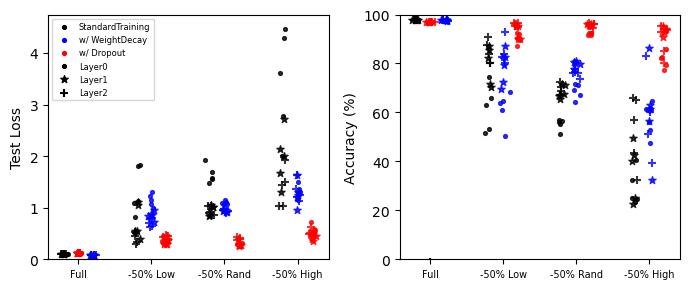

In [6]:
mkrSize = 30
rndSpread = 0.025
alpha = 0.8
fontsize=6
cmap = cm.get_cmap('Set1', numLayers-1).colors
mrkTypes=['.','*','+','x']

offset = 0.2
idxStandard = np.where(np.logical_and(pDropout==0,weightDecay==0))[0]
idxDropout = np.where(pDropout!=0)[0]
idxRegular = np.where(weightDecay!=0)[0]

fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].scatter(0, -1, color='k', s=mkrSize, marker='.', alpha=1, label='StandardTraining')
ax[0].scatter(0, -1, color='b', s=mkrSize, marker='.', alpha=1, label='w/ WeightDecay')
ax[0].scatter(0, -1, color='r', s=mkrSize, marker='.', alpha=1, label='w/ Dropout')
ax[1].scatter(0, -1, color='k', s=mkrSize, marker='.', alpha=1, label='StandardTraining')
ax[1].scatter(0, -1, color='r', s=mkrSize, marker='.', alpha=1, label='w/ Dropout')
ax[1].scatter(0, -1, color='b', s=mkrSize, marker='.', alpha=1, label='w/ WeightDecay')
for slayer in range(numLayers-1):
    ax[0].scatter(0, -1, color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
    ax[1].scatter(0, -1, color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
        
    ax[0].scatter(np.random.normal(0-offset,rndSpread,len(idxStandard)), loss[idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(0+0*offset,rndSpread,len(idxDropout)), loss[idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(0+1*offset,rndSpread,len(idxRegular)), loss[idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(1-offset,rndSpread,len(idxStandard)), lossNoLo[slayer,idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(2-offset,rndSpread,len(idxStandard)), lossRand[slayer,idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(3-offset,rndSpread,len(idxStandard)), lossNoHi[slayer,idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(1+1*offset,rndSpread,len(idxDropout)), lossNoLo[slayer,idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(2+1*offset,rndSpread,len(idxDropout)), lossRand[slayer,idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(3+1*offset,rndSpread,len(idxDropout)), lossNoHi[slayer,idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(1+0*offset,rndSpread,len(idxRegular)), lossNoLo[slayer,idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(2+0*offset,rndSpread,len(idxRegular)), lossRand[slayer,idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[0].scatter(np.random.normal(3+0*offset,rndSpread,len(idxRegular)), lossNoHi[slayer,idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    
    ax[1].scatter(np.random.normal(0-offset,rndSpread,len(idxStandard)), acc[idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(0+0*offset,rndSpread,len(idxDropout)), acc[idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(0+1*offset,rndSpread,len(idxRegular)), acc[idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(1-offset,rndSpread,len(idxStandard)), accNoLo[slayer,idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(2-offset,rndSpread,len(idxStandard)), accRand[slayer,idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(3-offset,rndSpread,len(idxStandard)), accNoHi[slayer,idxStandard], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(1+1*offset,rndSpread,len(idxDropout)), accNoLo[slayer,idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(2+1*offset,rndSpread,len(idxDropout)), accRand[slayer,idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(3+1*offset,rndSpread,len(idxDropout)), accNoHi[slayer,idxDropout], color='r', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(1+0*offset,rndSpread,len(idxRegular)), accNoLo[slayer,idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(2+0*offset,rndSpread,len(idxRegular)), accRand[slayer,idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
    ax[1].scatter(np.random.normal(3+0*offset,rndSpread,len(idxRegular)), accNoHi[slayer,idxRegular], color='b', s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)

xTickLabel=['Full',f'-{100*frac2dropout:.0f}% Low',f'-{100*frac2dropout:.0f}% Rand',f'-{100*frac2dropout:.0f}% High']
ax[0].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize+1)
ax[1].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize+1)
ax[0].set_ylim(0,None)
ax[1].set_ylim(0,100)
ax[0].set_ylabel('Test Loss')
ax[1].set_ylabel('Accuracy (%)')
ax[0].legend(fontsize=fontsize,loc='best')

plt.tight_layout();

In [7]:
# Plot eigenspectra from each layer
beta, eigenvalues, eigenvectors = [], [], []
for fres in tqdm(fullResults):
    cbeta, ceigenvalues, ceigenvectors = fres['net'].measureEigenFeatures(fres['net'], fres['trainloader'])
    beta.append(cbeta)
    eigenvalues.append(ceigenvalues)
    eigenvectors.append(ceigenvectors)

# Make nice arrays
NL = len(beta[0])
betaLayers = [[] for _ in range(NL)]
evalLayers = [[] for _ in range(NL)]
evecLayers = [[] for _ in range(NL)]
for layer in range(len(beta[0])):
    betaLayers[layer] = torch.stack([bl[layer] for bl in beta])
    evalLayers[layer] = np.stack([ev[layer] for ev in eigenvalues])
    evecLayers[layer] = np.stack([ev[layer] for ev in eigenvectors])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


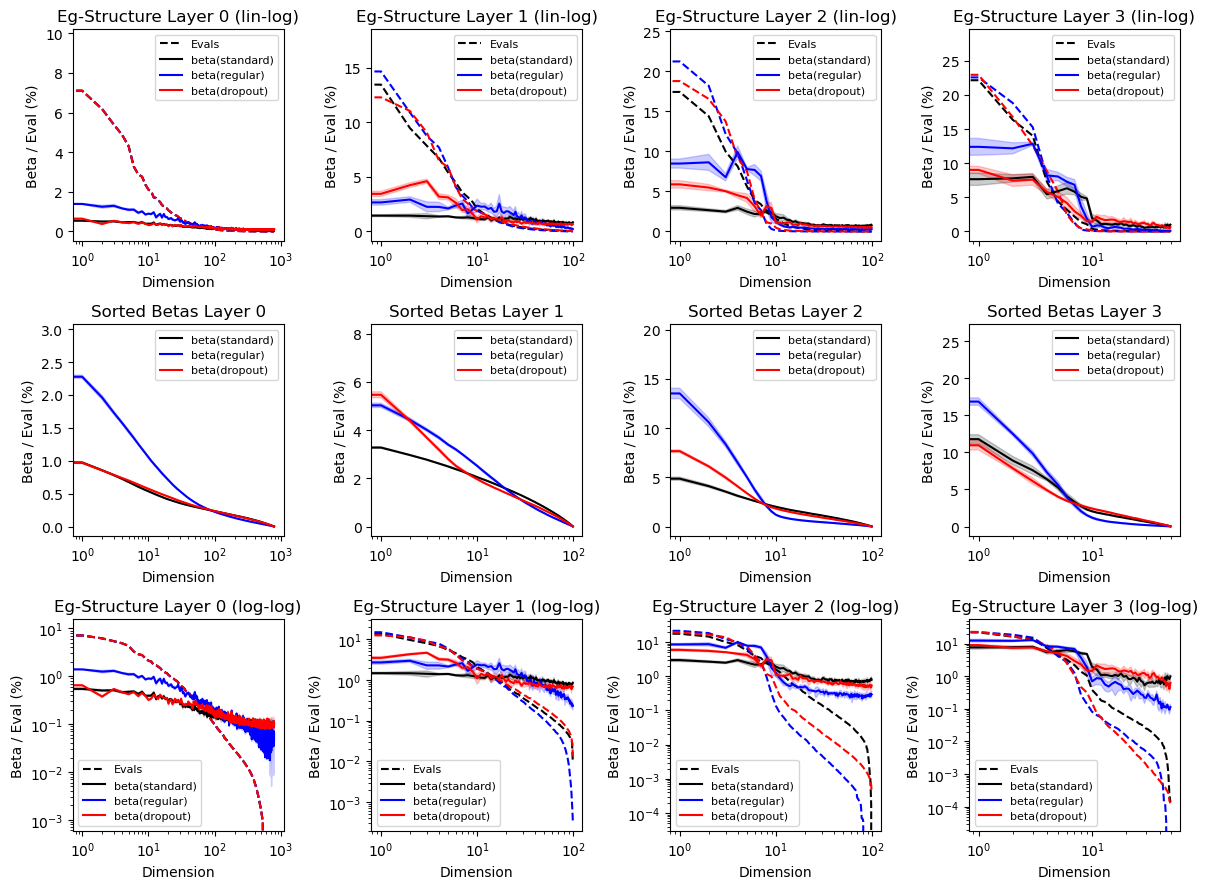

In [8]:
mkrSize = 30
rndSpread = 0.025
alpha = 0.8
fontsize=6
cmap = cm.get_cmap('Set1', numLayers-1).colors
mrkTypes=['.','*','+','x']

idxStandard = np.where(np.logical_and(pDropout==0,weightDecay==0))[0]
idxDropout = np.where(pDropout!=0)[0]
idxRegular = np.where(weightDecay!=0)[0]

fig,ax = plt.subplots(3,NL,figsize=(12,9))

for layer in range(NL):
    cNEV = evalLayers[layer].shape[1]
    normEvLayer = evalLayers[layer] / np.sum(evalLayers[layer],axis=1,keepdims=True)
    evStandard = 100*np.mean(normEvLayer[idxStandard],axis=0)
    evRegular = 100*np.mean(normEvLayer[idxRegular],axis=0)
    evDropout = 100*np.mean(normEvLayer[idxDropout],axis=0)
    
    normBetaLayer = betaLayers[layer] / torch.sum(betaLayers[layer],dim=2,keepdim=True)
    betaStandard = 100*torch.mean(normBetaLayer[idxStandard],dim=1)
    betaRegular = 100*torch.mean(normBetaLayer[idxRegular],dim=1)
    betaDropout = 100*torch.mean(normBetaLayer[idxDropout],dim=1)
    mnStandard = torch.mean(betaStandard,dim=0)
    seStandard = torch.std(betaStandard,dim=0)
    mnRegular = torch.mean(betaRegular,dim=0)
    seRegular = torch.std(betaRegular,dim=0)
    mnDropout = torch.mean(betaDropout,dim=0)
    seDropout = torch.std(betaDropout,dim=0)
    
    sortBetaLayer = torch.sort(normBetaLayer,dim=2,descending=True)[0]
    sortStandard = 100*torch.mean(sortBetaLayer[idxStandard],dim=1)
    sortRegular = 100*torch.mean(sortBetaLayer[idxRegular],dim=1)
    sortDropout = 100*torch.mean(sortBetaLayer[idxDropout],dim=1)
    mnStandardS = torch.mean(sortStandard,dim=0)
    seStandardS = torch.std(sortStandard,dim=0)
    mnRegularS = torch.mean(sortRegular,dim=0)
    seRegularS = torch.std(sortRegular,dim=0)
    mnDropoutS = torch.mean(sortDropout,dim=0)
    seDropoutS = torch.std(sortDropout,dim=0)
    
    # Plot eigenvalues for each training method
    ax[0,layer].plot(range(cNEV), evStandard, c='k', linestyle='--', label='Evals')
    ax[0,layer].plot(range(cNEV), evRegular, c='b', linestyle='--')
    ax[0,layer].plot(range(cNEV), evDropout, c='r', linestyle='--')
    # Plot beta projections for each training method
    ax[0,layer].fill_between(range(cNEV), mnStandard+seStandard, mnStandard-seStandard, color='k', alpha=0.2)
    ax[0,layer].fill_between(range(cNEV), mnRegular+seRegular, mnRegular-seRegular, color='b', alpha=0.2)
    ax[0,layer].fill_between(range(cNEV), mnDropout+seDropout, mnDropout-seDropout, color='r', alpha=0.2)
    ax[0,layer].plot(range(cNEV), mnStandard, c='k', label='beta(standard)')
    ax[0,layer].plot(range(cNEV), mnRegular, c='b', label='beta(regular)')
    ax[0,layer].plot(range(cNEV), mnDropout, c='r', label='beta(dropout)')
    # Axis Properties
    ax[0,layer].set_xscale('log')
    ax[0,layer].set_xlabel('Dimension')
    ax[0,layer].set_ylabel('Beta / Eval (%)')
    ax[0,layer].legend(loc='best',fontsize=8)
    ax[0,layer].set_title(f'Eg-Structure Layer {layer} (lin-log)')
    
    # Plot beta projections for each training method
    ax[1,layer].fill_between(range(cNEV), mnStandardS+seStandardS, mnStandardS-seStandardS, color='k', alpha=0.2)
    ax[1,layer].fill_between(range(cNEV), mnRegularS+seRegularS, mnRegularS-seRegularS, color='b', alpha=0.2)
    ax[1,layer].fill_between(range(cNEV), mnDropoutS+seDropoutS, mnDropoutS-seDropoutS, color='r', alpha=0.2)
    ax[1,layer].plot(range(cNEV), mnStandardS, c='k', label='beta(standard)')
    ax[1,layer].plot(range(cNEV), mnRegularS, c='b', label='beta(regular)')
    ax[1,layer].plot(range(cNEV), mnDropoutS, c='r', label='beta(dropout)')
    # Axis Properties
    ax[1,layer].set_xscale('log')
    ax[1,layer].set_xlabel('Dimension')
    ax[1,layer].set_ylabel('Beta / Eval (%)')
    ax[1,layer].legend(loc='best',fontsize=8)
    ax[1,layer].set_title(f'Sorted Betas Layer {layer}')
    
    # Plot eigenvalues for each training method
    ax[2,layer].plot(range(cNEV), evStandard, c='k', linestyle='--', label='Evals')
    ax[2,layer].plot(range(cNEV), evRegular, c='b', linestyle='--')
    ax[2,layer].plot(range(cNEV), evDropout, c='r', linestyle='--')
    # Plot beta projections for each training method
    ax[2,layer].fill_between(range(cNEV), mnStandard+seStandard, mnStandard-seStandard, color='k', alpha=0.2)
    ax[2,layer].fill_between(range(cNEV), mnRegular+seRegular, mnRegular-seRegular, color='b', alpha=0.2)
    ax[2,layer].fill_between(range(cNEV), mnDropout+seDropout, mnDropout-seDropout, color='r', alpha=0.2)
    ax[2,layer].plot(range(cNEV), mnStandard, c='k', label='beta(standard)')
    ax[2,layer].plot(range(cNEV), mnRegular, c='b', label='beta(regular)')
    ax[2,layer].plot(range(cNEV), mnDropout, c='r', label='beta(dropout)')
    # Axis Properties
    ax[2,layer].set_xscale('log')
    ax[2,layer].set_yscale('log')
    ax[2,layer].set_xlabel('Dimension')
    ax[2,layer].set_ylabel('Beta / Eval (%)')
    ax[2,layer].legend(loc='best',fontsize=8)
    ax[2,layer].set_title(f'Eg-Structure Layer {layer} (log-log)')
    
    
plt.tight_layout()

In [9]:
# Meausure signed betas of weight updates
print(len(fullResults[0]['allWeights']))
print(len(fullResults[0]['allWeights'][0]))
print(fullResults[0]['allWeights'][0][0].shape)

100
4
torch.Size([100, 784])


In [10]:
# For each layer, aWeightsLayer has shape: (numRuns, numOutWeights, numInWeights, trainingEpoch)
aWeightsLayer = [[] for _ in range(numLayers)]
for layer in tqdm(range(numLayers)):
    # Put each layers allWeight trajectory as a list 
    for runidx in range(numRuns):
        aWeightsLayer[layer].append(fullResults[runidx]['net'].layerFromFull(fullResults[runidx]['allWeights'], layer, dim=2))
    # Then concatenate 
    aWeightsLayer[layer] = torch.stack(aWeightsLayer[layer])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.16it/s]


In [11]:
# Measure signed normalized projection onto each eigenvector (using final eigenvectors)
sBetaCWeights = [[] for _ in range(numLayers)]
stdBetaCWeights = [[] for _ in range(numLayers)]
usBetaCWeights = [[] for _ in range(numLayers)]
ustdBetaCWeights = [[] for _ in range(numLayers)]
for layer in tqdm(range(numLayers)):
    cdWeights = torch.diff(aWeightsLayer[layer],n=1,dim=3)
    proj = np.einsum('roie,riv->rove',cdWeights.numpy(),evecLayers[layer])
    nproj = proj / np.linalg.norm(proj,axis=2,keepdims=True)
    pproj = np.abs(proj)  / np.sum(np.abs(proj) ,axis=2,keepdims=True)
    sBetaCWeights[layer] = np.mean(nproj,axis=1) # avg projection across units in layer (numRuns, numEigenvectors, numWeightMeasurements-1)
    stdBetaCWeights[layer] = np.std(nproj,axis=1) # std projection 
    usBetaCWeights[layer] = np.mean(pproj,axis=1) # avg projection across units in layer (numRuns, numEigenvectors, numWeightMeasurements-1)
    ustdBetaCWeights[layer] = np.std(pproj,axis=1) # std projection 

 25%|█████████████████████                                                               | 1/4 [00:41<02:05, 41.81s/it]C:\Users\andrew\AppData\Local\Temp\ipykernel_23304\2214963808.py:9: RuntimeWarning: invalid value encountered in true_divide
  nproj = proj / np.linalg.norm(proj,axis=2,keepdims=True)
C:\Users\andrew\AppData\Local\Temp\ipykernel_23304\2214963808.py:10: RuntimeWarning: invalid value encountered in true_divide
  pproj = np.abs(proj)  / np.sum(np.abs(proj) ,axis=2,keepdims=True)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.81s/it]


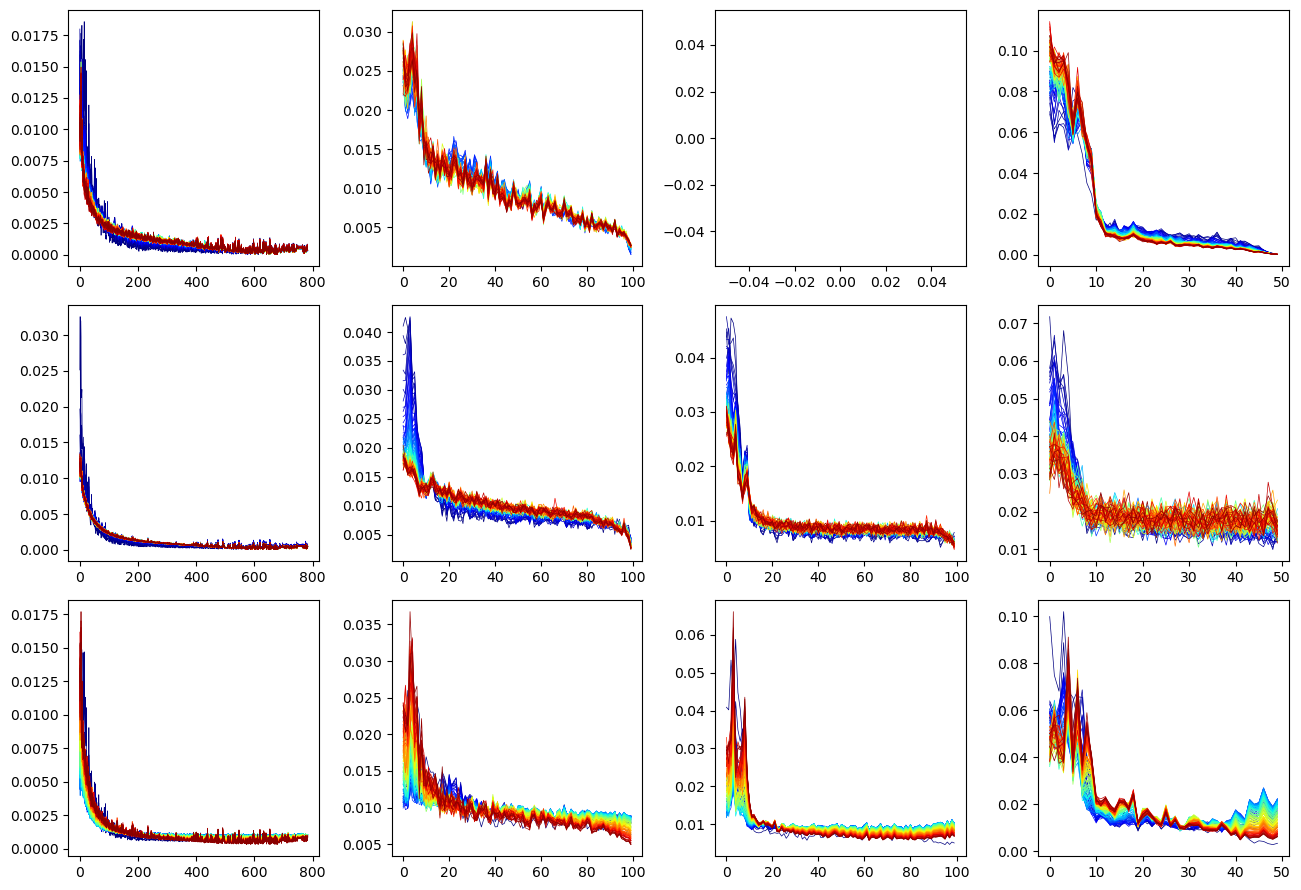

In [12]:
trainingEpochs = aWeightsLayer[layer].shape[3]
idxStandard = np.where(np.logical_and(pDropout==0,weightDecay==0))[0]
idxDropout = np.where(pDropout!=0)[0]
idxRegular = np.where(weightDecay!=0)[0]

colorNorm = colors.Normalize(vmin=0,vmax=trainingEpochs-1)
getColor = lambda s : cm.jet(colorNorm(s))

fig,ax = plt.subplots(3,numLayers,figsize=(13,9))
for layer in range(numLayers):
    cNEV = sBetaCWeights[layer].shape[1]
    for te in range(trainingEpochs-1):
        ax[0,layer].plot(range(cNEV), np.mean(usBetaCWeights[layer][idxStandard,:,te],axis=0), c=getColor(te), linewidth=0.5)
        ax[1,layer].plot(range(cNEV), np.mean(usBetaCWeights[layer][idxDropout,:,te],axis=0), c=getColor(te), linewidth=0.5)
        ax[2,layer].plot(range(cNEV), np.mean(usBetaCWeights[layer][idxRegular,:,te],axis=0), c=getColor(te), linewidth=0.5)

plt.tight_layout()

In [9]:
# Measure alignment of the change in weight vectors
# --ATL-- Note: this is a little meaningless because it ignores information about changes in alignment of the actual weights (need signed betas for this!)
# -------       or just need to figure out the math to calculate the derivative of the alignment with respect to a change in weights...

# Get net change in weights
changeWeights = []
for fres in fullResults:
    cInitWeights = fres['initWeights']
    cFinalWeights = fres['net'].getNetworkWeights()
    changeWeights.append([cf.clone().detach().cpu().numpy()-ci.clone().detach().cpu().numpy() for cf,ci in zip(cInitWeights, cFinalWeights)])

# Convert to useful array
changeWeightsLayer = [[] for _ in range(NL)]
for layer in range(NL):
    changeWeightsLayer[layer] = np.stack([cw[layer] for cw in changeWeights])
    
# Measure alignment of each
alignChangeLayer = [[] for _ in range(NL)]
for layer in range(NL):
    cacl = []
    for cw,ceval,cevec in zip(changeWeightsLayer[layer],evalLayers[layer],evecLayers[layer]):
        ccov = cevec @ np.diag(ceval) @ cevec.T
        rq = np.sum((cw @ ccov) * cw, axis=1) / np.sum(cw * cw,axis=1) / np.trace(ccov) 
        cacl.append(rq)
    alignChangeLayer[layer] = np.stack(cacl)

C:\Users\andrew\AppData\Local\Temp\ipykernel_20504\692631066.py:21: RuntimeWarning: invalid value encountered in true_divide
  rq = np.sum((cw @ ccov) * cw, axis=1) / np.sum(cw * cw,axis=1) / np.trace(ccov)


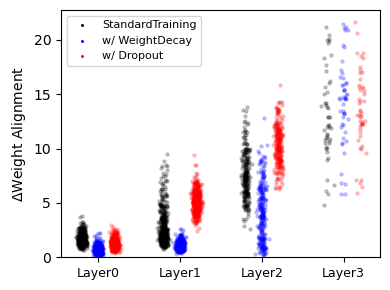

In [10]:
mkrSize = 5
rndSpread = 0.025
alpha = 0.2
fontsize=8
cmap = cm.get_cmap('Set1', numLayers-1).colors
mrkTypes=['.','*','+','x']

offset = 0.2
idxStandard = np.where(np.logical_and(pDropout==0,weightDecay==0))[0]
idxDropout = np.where(pDropout!=0)[0]
idxRegular = np.where(weightDecay!=0)[0]

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.scatter(0, -1, color='k', s=mkrSize, marker='.', alpha=1, label='StandardTraining')
ax.scatter(0, -1, color='b', s=mkrSize, marker='.', alpha=1, label='w/ WeightDecay')
ax.scatter(0, -1, color='r', s=mkrSize, marker='.', alpha=1, label='w/ Dropout')
for slayer in range(numLayers):
    ax.scatter(np.random.normal(slayer-offset,rndSpread,len(idxStandard)*alignChangeLayer[slayer].shape[1]),100*alignChangeLayer[slayer][idxStandard], color='k', s=mkrSize, alpha=alpha)
    ax.scatter(np.random.normal(slayer+0*offset,rndSpread,len(idxRegular)*alignChangeLayer[slayer].shape[1]),100*alignChangeLayer[slayer][idxRegular], color='b', s=mkrSize, alpha=alpha)
    ax.scatter(np.random.normal(slayer+1*offset,rndSpread,len(idxDropout)*alignChangeLayer[slayer].shape[1]),100*alignChangeLayer[slayer][idxDropout], color='r', s=mkrSize, alpha=alpha)
    
xTickLabel=['Full',f'-{100*frac2dropout:.0f}% Low',f'-{100*frac2dropout:.0f}% Rand',f'-{100*frac2dropout:.0f}% High']
ax.set_xticks([0,1,2,3],labels=[f'Layer{layer}' for layer in range(numLayers)],fontsize=fontsize+1)
ax.set_ylim(0,None)
ax.set_ylabel(f'$\Delta$Weight Alignment')
ax.legend(fontsize=fontsize,loc='best')

plt.tight_layout();

In [11]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

# vals = np.ones((N, 4))
# vals[:, 0] = np.linspace(90/256, 1, N)
# vals[:, 1] = np.linspace(39/256, 1, N)
# vals[:, 2] = np.linspace(41/256, 1, N)
# newcmp = ListedColormap(vals)

def plot_rf(rf, width, alignment=None, alignBounds=None, showRFs=None, figSize=5):
    if showRFs is not None: 
        rf = rf.reshape(rf.shape[0], -1)
        idxRandom = np.random.choice(range(rf.shape[0]),showRFs,replace=False)
        rf = rf[idxRandom,:]
    else: 
        showRFs = rf.shape[0]
    # normalize
    rf = rf.T / np.abs(rf).max(axis=1)
    rf = rf.T
    rf = rf.reshape(showRFs, width, width)
    # If necessary, create colormap
    if alignment is not None:
        cmap = cm.get_cmap('rainbow', rf.shape[0])
        cmapPeak = lambda x : cmap(x)
        if alignBounds is not None:
            alignment = alignment - alignBounds[0]
            alignment = alignment / (alignBounds[1] - alignBounds[0])
        else:
            alignment = (alignment - alignment.min())
            alignment = alignment / alignment.max()
        
    # plotting
    n = int(np.ceil(np.sqrt(rf.shape[0])))
    fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True)
    fig.set_size_inches(figSize,figSize)
    
    N = 1000
    for i in tqdm(range(rf.shape[0])):
        ax = axes[i // n][i % n]
        if alignment is not None:
            vals = np.ones((N, 4))
            cAlignment = alignment[i].numpy()
            cPeak = cmapPeak(alignment[i].numpy())
            vals[:, 0] = np.linspace(0, cPeak[0], N)
            vals[:, 1] = np.linspace(0, cPeak[1], N)
            vals[:, 2] = np.linspace(0, cPeak[2], N)
            usecmap = ListedColormap(vals)
            ax.imshow(rf[i], cmap=usecmap, vmin=-1, vmax=1)
        else:
            ax.imshow(rf[i], cmap='gray', vmin=-1, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    for j in range(rf.shape[0], n * n):
        ax = axes[j // n][j % n]
        ax.imshow(np.ones_like(rf[0]) * -1, cmap='gray', vmin=-1, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    return fig

First layer recepetive fields -- standard training


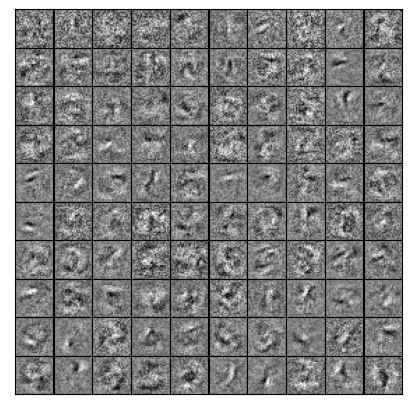

First layer recepetive fields -- with dropout


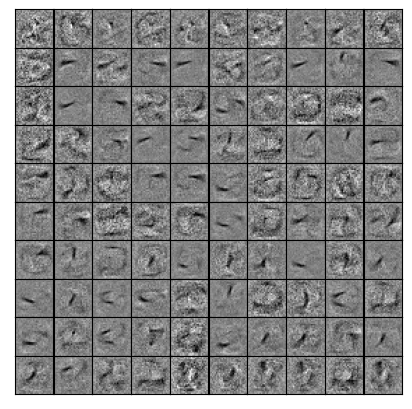

First layer recepetive fields -- with regularization


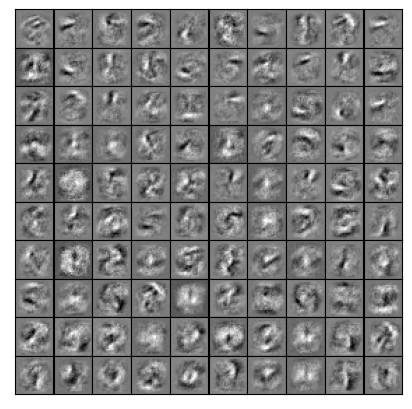

In [70]:
# Make a colormap for alignmnet! 
layer = 0
layerName = {0:'fc1', 1:'fc2', 2:'fc3', 3:'fc4'}
alignBounds = (alignLayer[layer][:,:,-1].min(), alignLayer[layer][:,:,-1].max())

# First Run
runidx = 0
idxAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
alignment = alignLayer[layer][runidx,idxAlignment,-1]
weight = getattr(fullResults[runidx]['net'],layerName[layer]).weight.data.clone().detach().cpu().numpy()[idxAlignment]
print('First layer recepetive fields -- standard training')
fig1 = plot_rf(weight, int(np.sqrt(weight.shape[1])), alignment=None, alignBounds=alignBounds)
plt.show(fig1)

# Second run
runidx = 10
idxAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
alignment = alignLayer[layer][runidx,idxAlignment,-1]
weight = getattr(fullResults[runidx]['net'],layerName[layer]).weight.data.clone().detach().cpu().numpy()[idxAlignment]
print('First layer recepetive fields -- with dropout')
fig2 = plot_rf(weight, int(np.sqrt(weight.shape[1])), alignment=None, alignBounds=alignBounds)
plt.show(fig2)

# Second run
runidx = 5
idxAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
alignment = alignLayer[layer][runidx,idxAlignment,-1]
weight = getattr(fullResults[runidx]['net'],layerName[layer]).weight.data.clone().detach().cpu().numpy()[idxAlignment]
print('First layer recepetive fields -- with regularization')
fig3 = plot_rf(weight, int(np.sqrt(weight.shape[1])), alignment=None, alignBounds=alignBounds)
plt.show(fig3)

In [231]:
# Make a plot of second layer activity where we multiply the second layer weights on the first layer RFs to see what the second layer likes to see :)
# heh

In [92]:
# Measure eigenvectors of images
allImages = []
for images,label in fullResults[0]['trainloader']:
    allImages.append(images)
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEvec = imEvec[:,idxEval]
NEV = len(imEval)

In [94]:
# Measure dot product of first layer weights on eigenvectors
beta = []
for res in fullResults:
    w1 = res['net'].fc1.weight.clone().cpu().detach()
    w1 = w1 / torch.norm(w1,dim=1,keepdim=True)
    beta.append(torch.abs(imEvec.T @ w1.T))
    
beta = torch.stack(beta)

Eigenvectors (highest to lowest eigenvalues)


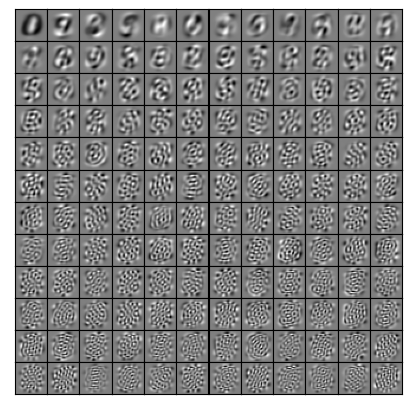

In [81]:
print('Eigenvectors (highest to lowest eigenvalues)')
fig4 = plot_rf(imEvec[:,:144].T.numpy(), int(np.sqrt(imEvec.shape[1])))
plt.show(fig4)

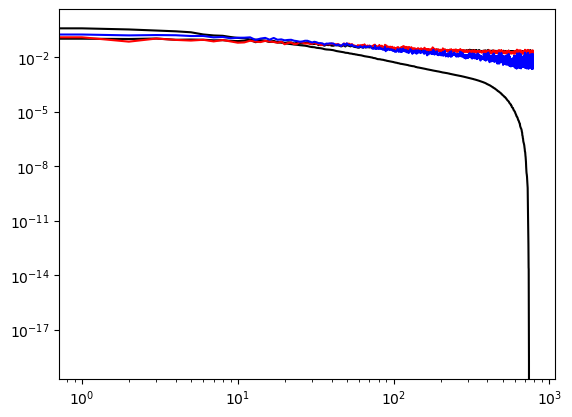

In [101]:
idxStandard = np.where(np.logical_and(pDropout==0,weightDecay==0))[0]
idxDropout = np.where(pDropout!=0)[0]
idxRegular = np.where(weightDecay!=0)[0]

plt.plot(range(NEV), imEval/100, c='k', linewidth=1.5)
plt.plot(range(NEV), torch.mean(beta[idxStandard], dim=(0,2)), c='k')
plt.plot(range(NEV), torch.mean(beta[idxDropout], dim=(0,2)), c='r')
plt.plot(range(NEV), torch.mean(beta[idxRegular], dim=(0,2)), c='b')
plt.xscale('log')
plt.yscale('log')

In [138]:
def manualShape(net,evals,evecs,evalTransform=lambda x:x):
    betas = []
    netweights = net.getNetworkWeights()
    for evc,nw in zip(evecs,netweights):
        nw = nw / torch.norm(nw,dim=1,keepdim=True)
        betas.append(nw.cpu() @ evc)
    
    keepFraction = evalTransform(evals[0]/np.sum(evals[0]))
    
    # Plan of attack:
    # 1. measure norm of weights
    # 2. make (out,in,in) tensor of the eigenvectors composing each weight vector scaled by the respective beta
    # 3. multiply that tensor by the keepFraction
    # 4. sum across eigenvectors, renormalize
    # 5. reassign weights
    
    keep1s = np.ones_like(keepFraction)
    weightNorms = torch.norm(net.fc1.weight.data,dim=1,keepdim=True) # measure norm of weights (this will be invariant to the change)
    evecComposition = torch.einsum('oi,xi->oxi',betas[0],torch.tensor(evecs[0]))
    newComposition = torch.einsum('oxi,i->ox',evecComposition,torch.tensor(keepFraction))
    renormComposition = newComposition / torch.norm(newComposition,dim=1,keepdim=True) * weightNorms
    

In [143]:
net = models.MLP4()
w1,n1 = manualShape(net, beta[0], eigenvalues[0], eigenvectors[0])
print(np.mean(w1 - n1))

4
4
4
torch.Size([100, 784])
(784,)
(784, 784)
torch.Size([100, 784])
False
-4.1418713e-10


In [140]:
w1.shape

(100, 784)

In [141]:
n1.shape

(100, 784)

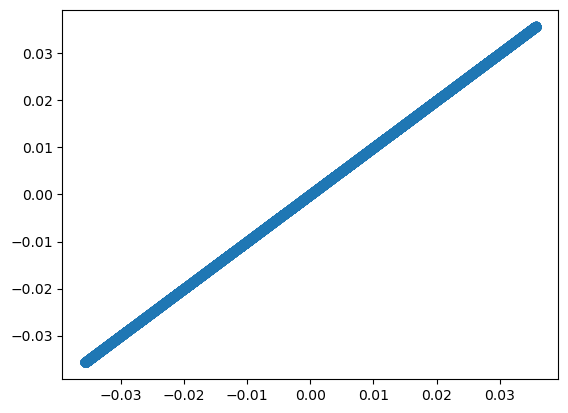

In [142]:
plt.scatter(w1[:],n1[:])